# Prepare Tetris emulator data

The data recorded while playing the game needs to be checked and cleaned before being used to train a model.

In [1]:
import os
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt

from recording import FileBasedDatabaseWithEvents

In [2]:
db_rec = FileBasedDatabaseWithEvents("recordings")
db = FileBasedDatabaseWithEvents(os.path.join("data", "tetris_emulator"))
db_train = FileBasedDatabaseWithEvents(os.path.join("data", "tetris_emulator", "train"))
db_test = FileBasedDatabaseWithEvents(os.path.join("data", "tetris_emulator", "test"))
print(f"{db_rec._path} has {len(db_rec)} files.")
print(f"{db._path} has {len(db)} files.")
print(f"{db_train._path} has {len(db_train)} files.")
print(f"{db_test._path} has {len(db_test)} files.")

recordings has 51 files.
data\tetris_emulator has 0 files.
data\tetris_emulator\train has 0 files.
data\tetris_emulator\test has 0 files.


In [3]:
# Move files from recordings folder to our dataset
for boards, events in db_rec:
    db.insert(boards, events)

print(f"Moved data from {db_rec._path} to {db._path}")

db_rec.delete_all()

Moved data from recordings to data\tetris_emulator


In [4]:
# Check we can read the files

boards, events = next(iter(db))
print(f"boards: shape {boards.shape}, dtype {boards.dtype}")
print(f"events: shape {events.shape}, dtype {events.dtype}")

boards: shape (2, 22, 10), dtype int32
events: shape (1,), dtype int32


pygame 2.4.0 (SDL 2.26.4, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


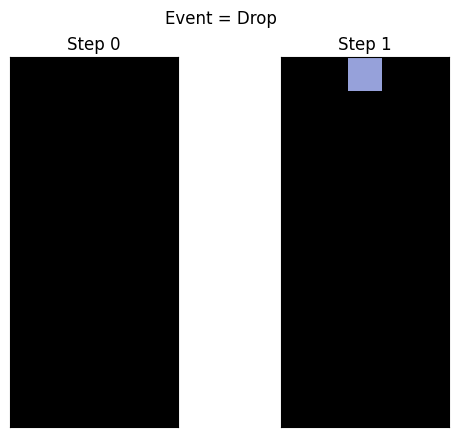

In [5]:
from tetris import CELL_COLORS
from engines import EVENT_NAMES


def render_boards(boards):
    batch_size, height, width = boards.shape
    imgs = np.zeros((batch_size, height, width, 3), dtype=np.int32)
    for idx in range(batch_size):
        for row in range(height):
            for col in range(width):
                imgs[idx, row, col, :] = CELL_COLORS[boards[idx, row, col]]
    return imgs



def show_example(boards, events):
    imgs = render_boards(boards)
    event_name = EVENT_NAMES[events.item()]

    fig, axs = plt.subplots(1, len(boards))
    fig.suptitle(f"Event = {event_name}")

    for i, ax in enumerate(axs):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(f"Step {i}")
        ax.imshow(imgs[i])

    plt.show()


show_example(boards, events)

Showing example 37


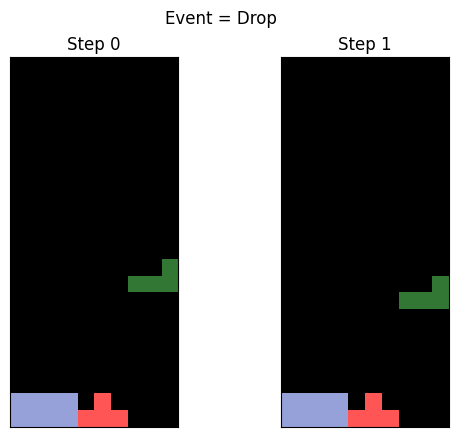

In [8]:
# Show a random example from the training set. Run this repeatedly to get an overview of the data.

idx = random.randrange(len(db))
print(f"Showing example {idx}")
boards, events = db[idx]
show_example(boards, events)

# Train/test split

We split the data into training and test data.

In [9]:
test_split = 0.2
test_count = int(test_split * len(db))
train_count = len(db) - test_count

idxs = list(range(len(db)))
random.shuffle(idxs)

for idx in range(train_count):
    boards, events = db[idxs[idx]]
    db_train.insert(boards, events)

for idx in range(train_count, len(db)):
    boards, events = db[idxs[idx]]
    db_test.insert(boards, events)

print(f"Files split into {train_count} training and {test_count} test examples.")

Files split into 41 training and 10 test examples.


In [10]:
# Clean up old database
db.delete_all()

# Post-split checks

Let's check the number of each type of block spawn in both the training and test folder.

In [11]:
import torch
from torch.utils.data import Dataset

class RecordingDataset(Dataset):
    def __init__(self, db: FileBasedDatabaseWithEvents):
        self.db = db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, idx):
        boards, events = self.db[idx]
        x = torch.tensor(boards[-2]) # Ignore all boards except the last two
        e = torch.tensor(events[-1])
        y = torch.tensor(boards[-1], dtype=torch.long)
        return (x, e), y
        

In [12]:
class BlockType:
    I = "I"
    O = "O"
    T = "T"
    Z = "Z"
    S = "S"
    J = "J"
    L = "L"
    All = [I, O, T, Z, S, J, L]
    
def get_block_spawn_type(example):
    (x, e), y = example
    if (x[0, :] > 0).any() | (y[0, :] == 0).all():
        return None
    if (y[1, :] == 0).all():
        return BlockType.I
    if y[0, 3] > 0:
        if y[1, 3] > 0:
            return BlockType.J
        else:
            if y[0, 5] > 0:
                return BlockType.T
            else:
                return BlockType.Z
    else:
        if y[1, 3] > 0:
            if y[0, 4] > 0:
                return BlockType.S
            else:
                return BlockType.L
        else:
            return BlockType.O


def count_block_spawns_by_type(dataset):
    spawns_by_type = {block_type: 0 for block_type in BlockType.All}
    for example in dataset:
        spawn_type = get_block_spawn_type(example)
        if spawn_type is not None:
            spawns_by_type[spawn_type] += 1
    return spawns_by_type


def describe_block_spawns(dataset):
    spawns_by_type = count_block_spawns_by_type(dataset)
    print(spawns_by_type)
    
    num_block_spawns = sum(val for key, val in spawns_by_type.items() if key is not None)
    frac_block_spawns = num_block_spawns / len(dataset)
    print(f"Dataset has {num_block_spawns} block spawns.")


train_dataset = RecordingDataset(db_train)
test_dataset = RecordingDataset(db_test)

print("Describing training dataset...")
describe_block_spawns(train_dataset)
print()
print("Describing test dataset...")
describe_block_spawns(test_dataset)

Describing training dataset...
{'I': 0, 'O': 2, 'T': 1, 'Z': 0, 'S': 1, 'J': 0, 'L': 1}
Dataset has 5 block spawns.

Describing test dataset...
{'I': 0, 'O': 0, 'T': 0, 'Z': 0, 'S': 0, 'J': 0, 'L': 0}
Dataset has 0 block spawns.
